In [5]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
random.seed(7)

In [14]:
qpa = qparray.QpixAsicArray(2, 2, debug=0.0, deltaT=2e-6)
# print(qpa._daqNode.daqHits)
qpa.Calibrate(0.003)
print(qpa._daqNode.hitData.items())

# qpa.Calibrate(0.003)
# print()
# print(qpa._daqNode.daqData.items())

# guessFrq = {}
# for k, v in qpa._daqNode.hitData.items():
#     asic = k
#     daqTicks = []
#     asicTicks = []
#     for daqTick, asicTick in v:
#         daqTicks.append(daqTick)
#         asicTicks.append(asicTick.data)
#     print("asic ticks:", asicTicks)
#     guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[1] - daqTicks[0])  * qpa._daqNode.fOsc
# for asic in qpa:
#     key = f"({asic.row}, {asic.col})"
#     print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")

dict_items([('(0, 0)', []), ('(0, 1)', []), ('(1, 0)', []), ('(1, 1)', [])])


Text(0.5, 1.0, 'ASIC Frequency Error Calculation')

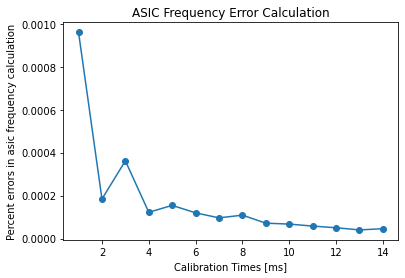

In [15]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
random.seed(7) 
# investigate why some random seeds allow you to do several calibrations and others dont, maybe it is with the asic oscillation frequency?


row = 2
col = 2

GuessFreqArray = []
PercDiffArray = {}
Keys = []
CalibrateThroughTimes = np.arange(1, 15) * 1e-3
freq = {}

for number, CalTime in enumerate(CalibrateThroughTimes):
    q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-6, timeEpsilon = 2e-6, timeout=1000)
    q.Calibrate(CalTime)

    guessFrq = {}
    for k, v in q._daqNode.askData.items():
        asic = k
        daqTicks = []
        asicTicks = []
        for daqTick, Byte in v:
            daqTicks.append(daqTick)
            asicTicks.append(Byte.data) # Byte[4] or Byte.data depending what is appended
        if len(asicTicks) < 2:
            print(f'\nno work fo da calibration time {CalTime}: ')
            for asic in q:
                print(f'osc freq: {asic.fOsc}')
                print(f'start time {asic._startTime}')
                print()

        # print("asic ticks:", asicTicks)
        guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[-1] - daqTicks[-2])  * q._daqNode.fOsc
        GuessFreqArray.append(guessFrq[asic])
        # print(f'appending {guessFrq[asic]} for asic {asic}')

    for asic in q:
        key = f"({asic.row}, {asic.col})"
        if key not in Keys: Keys.append(key)
        # print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")
        percdiff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
        if key not in PercDiffArray:
            PercDiffArray[key] = []
        PercDiffArray[key].append(percdiff)

#################################################
## PLOTTING

import pylab as p

plot = np.zeros((len(CalibrateThroughTimes)))
for runs in range(len(CalibrateThroughTimes)):
    somethingcreative = []
    for key in Keys:
        # print(key)
        # print(np.absolute(PercDiffArray[key][runs]))
        somethingcreative.append(np.absolute(PercDiffArray[key][runs]))
    plot[runs] = sum(somethingcreative) / len(Keys);

p.plot(CalibrateThroughTimes * 1e3, plot, linestyle='-', marker='o');
p.xlabel('Calibration Times [ms]')
p.ylabel('Percent errors in asic frequency calculation')
p.title('ASIC Frequency Error Calculation')

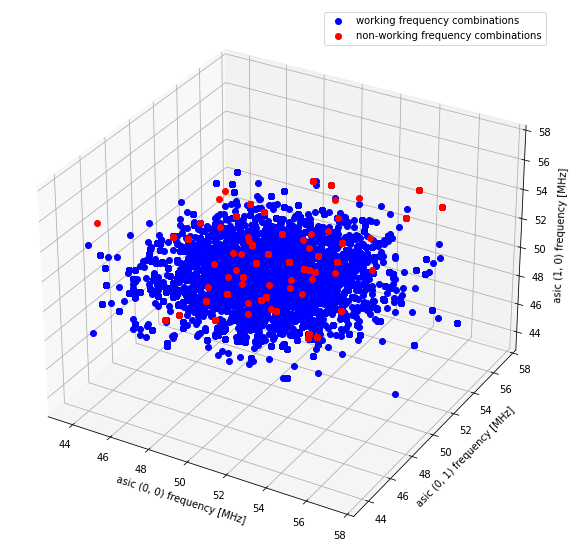

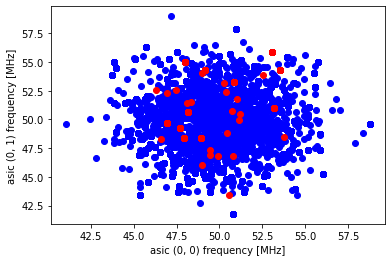

In [43]:
## THIS PROBLEM CAN PROBABLY SOLVED BY MESSING WITH THE TIMEOUT TIME
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np

row = 2
col = 2

CalTimes = np.arange(1, 20) * 1e-3
WorkingFreq = np.zeros((100000, 4))
NonWorkingFreq = np.zeros((100000, 4))
step = 0

for j in range(1000):
    random.seed(random.randint(0, 100000))
    for i in CalTimes:
        q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-5, timeEpsilon = 2e-6, timeout=2000)
        q.Interrogate(interval=i, duration=4*i)
        if q._alert:
            for index, asic in enumerate(q):
                NonWorkingFreq[step, index] = asic.fOsc
        else:
            for index, asic in enumerate(q):
                WorkingFreq[step, index] = asic.fOsc
        step+=1

WorkingFreq = WorkingFreq[NonWorkingFreq[:,0] == 0]
WorkingFreq = WorkingFreq[WorkingFreq[:, 0] > 0, 0:3] * 1e-6
NonWorkingFreq = NonWorkingFreq[NonWorkingFreq[:, 0] > 0, 0:3] * 1e-6

###################################
# PLOTTING

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlim(43, 58)
ax.set_xlabel('asic (0, 0) frequency [MHz]')
ax.set_ylim(43, 58)
ax.set_ylabel('asic (0, 1) frequency [MHz]')
ax.set_zlim(43, 58)
ax.set_zlabel('asic (1, 0) frequency [MHz]')

ax.plot(*WorkingFreq, marker = 'o', color = 'blue', linestyle = '');
ax.plot(*NonWorkingFreq, marker = 'o', color = 'red', linestyle = '');
ax.legend(('working frequency combinations', 'non-working frequency combinations'));
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.show()

plt.plot(WorkingFreq[:,0], WorkingFreq[:,1], marker = 'o', color = 'blue', linestyle = '')
plt.plot(NonWorkingFreq[:,0], NonWorkingFreq[:, 1], marker = 'o', color = 'red', linestyle = '')
plt.xlabel('asic (0, 0) frequency [MHz]')
plt.ylabel('asic (0, 1) frequency [MHz]')
plt.show()

timeout 1000.0s works for an array of 1 x 1 asics
timeout 27000.0s works for an array of 2 x 1 asics
timeout 77000.0s works for an array of 2 x 2 asics
timeout 125000.0s works for an array of 3 x 2 asics
timeout 209000.0s works for an array of 3 x 3 asics
timeout 273000.0s works for an array of 4 x 3 asics
timeout 375000.0s works for an array of 4 x 4 asics
timeout 483000.0s works for an array of 5 x 4 asics
timeout 611000.0s works for an array of 5 x 5 asics
timeout 739000.0s works for an array of 6 x 5 asics


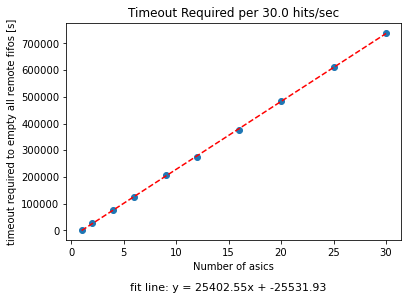

In [1]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
import pylab as p
from scipy.optimize import curve_fit as cf
random.seed(7)

DIRECTIONS = ("North", "East", "South", "West")

row = 1
col = 1
iters = 10
WorkingTimeoutArray = np.zeros((iters, 2))
toggle = True
TimeoutArray = np.arange(1, 1000, 2) * 1e3

for tiledim in range(iters):

    for timeout in TimeoutArray:
        timeoutwork=0
        array = qparray.QpixAsicArray(row, col, deltaT=1e-4, timeout=timeout, hitsPerSec=30.)
        array.Interrogate(interval=.2, duration=.4)
        for asic in array:
            for direc in range(4):
                CurSize = asic._remoteFifos[direc]._curSize
                if CurSize > 0:
                    timeoutwork+=1
        if timeoutwork == 0:
            print(f'timeout {timeout}s works for an array of {row} x {col} asics')
            WorkingTimeoutArray[tiledim, 0] = row * col
            WorkingTimeoutArray[tiledim, 1] = timeout
            if toggle:
                row+=1
            else:
                col+=1
            toggle = not(toggle)
            break
    if timeout == TimeoutArray[-1]:
        break

xvalues = WorkingTimeoutArray[:, 0]
yvalues = WorkingTimeoutArray[:, 1]

def FitFunc(x, a, b):
    return a * x + b

popt, pcov = cf(FitFunc, xvalues, yvalues)

p.plot(xvalues, yvalues, marker='o', linestyle='')
p.plot(xvalues, FitFunc(xvalues, *popt), linestyle = '--', color = 'red')
p.title(f'Timeout Required per {array._asics[0][0].randomRate} hits/sec')
p.xlabel('Number of asics')
p.ylabel('timeout required to empty all remote fifos [s]')
txt = f'fit line: y = {popt[0]:2.2f}x + {popt[1]:2.2f}'
p.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11);

In [1]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np

row = 2
col = 2
numOfAsics = row * col
array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
    timeout=2.2e4 * numOfAsics - 1.6e4, hitsPerSec = 1./1.)


# array.Interrogate(interval=0.1)

## setup
## inject hits into asics
times = [1, 1.1, 3]
asic = array[0][1]
asic._InjectHits(times=times, channels=[[1, 2, 13]]*len(times))

## main
t = 0
int_frq = 0.5 # look every second
stop = 1.6  # 100s of data
while t < stop:
    array.Interrogate(int_frq)
    t += int_frq

for asic in array:
    key = f'({asic.row}, {asic.col})'
    print(f'the ask data and hit data for asic {key} is ', end="")
    print(len(array._daqNode.askData[key]), end=" and ")
    print(len(array._daqNode.hitData[key]))


# ## look at buffers
# for asic in array:
#     asic.PrintFifoInfo()


injecting hits for (0, 1)
injected hits are at times (1, 1.1, 3) and ch ([1, 2, 13], [1, 2, 13], [1, 2, 13])
performing interrogation..
interrogation complete in 14 steps
interrogates at 3.5926817076870066e-13s 

performing interrogation..
interrogation complete in 14 steps
interrogates at 0.5000099999980838s 

performing interrogation..
interrogation complete in 16 steps
interrogates at 1.0000100000013594s 

performing interrogation..
interrogation complete in 16 steps
interrogates at 1.500010000004635s 

the ask data and hit data for asic (0, 0) is 4 and 0
the ask data and hit data for asic (0, 1) is 4 and 2
the ask data and hit data for asic (1, 0) is 4 and 0
the ask data and hit data for asic (1, 1) is 4 and 0


In [4]:
import numpy as np

times = []
for i in [1, 1.1, 3]:
    times.append(i)

mincedmeet = np.array([4, 4, 4])
log = [True, True, False]

TypeError: can't multiply sequence by non-int of type 'list'

In [13]:
random.seed(7)

time = [0, 1, 2]

pixels = []
[pixels.append([]) for i in range(len(times))]
for i in range(len(times)):
    NumOfChan = int(np.absolute(np.ceil(random.gauss(1.5, 2))))
    for channels in range(NumOfChan):
        pixels[i].append(random.randint(0, 16))
print(f'pixels is {pixels}')

for ch, inTime in zip(pixels, time):
    print(f'channel is {ch[0]}')
    for addThis in ch[1:]:
        print(f'this will be added {addThis}')
    print(f'time is {inTime}')


    # if times is None:
    #   times = np.linspace(0.01, 0.1, 10)
    #   self._times = times
    #   times = self._times[self._times <= targetTime]
    #   TimesIndex = np.logical_and(self._times > self._lastAsicHitTime, self._times <= targetTime)

    # else:
    #   self._time
    #   TimesIndex = np.logical_and(self._times > self._lastAsicHitTime, self._times <= targetTime)
    #   times = self._times[TimesIndex]
    #   print(f'the indexed times are {times}')


    # # append a number of empty lists to pixel list to match size of times array
    # # then assign a random number of random channels to the lists
    # if channels is None:
    #   channels = []
    #   [channels.append([]) for i in range(len(self._times))]
    #   for i in range(len(channels)):
    #       NumOfChan = int(np.absolute(np.ceil(random.gauss(2.5, 2))))
    #       for pixels in range(NumOfChan):
    #         newChan = random.randint(0, 16)
    #         if newChan not in channels[i]:
    #           channels[i].append(newChan)
    #   self._channels = channels
    #   channels = [self._channels for (self._channels, TimesIndex) in zip(self._channels, TimesIndex) if TimesIndex]
    
    # else:
    #   channels = [self._channels for (self._channels, TimesIndex) in zip(self._channels, TimesIndex) if TimesIndex]
    #   print(f'the indexed channels are {channels}')
    #   print(f'the whole channel list is {self._channels}')

    # if len(channels) > 0:
    #   times, channels = zip(*sorted(zip(times, channels)))
    
    # else:
    #   print(f'there are no hits at {self._absTimeNow}s')
    #   return 0
    
    # self._lastAsicHitTime = targetTime
    
    # return len(newHits)
    

pixels is [[1], [2, 3, 11], [6, 1]]
channel is 1
time is 0
channel is 2
this will be added 3
this will be added 11
time is 1
channel is 6
this will be added 1
time is 2
